In [2]:
import sys
import requests
import xlsxwriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from json import loads
from datetime import date
from dateutil.relativedelta import relativedelta

### Function for Transforming DataFrame in Excel Object

In [3]:
#Function for Writing .xlsx Data Tables which will provide a standard output for table formatting 
def xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer):

    #Layout/Formatting
    t_vert_spacing = 5 #Vertical Spacing between tables
    t_horz_spacing = 1 #Horizontal Spacing between tables
    title_format = workbook.add_format({'bold': True, 'font_size' : 20, 'fg_color' : '#76933C', 'font_color' : 'white' }) #Standardised Title Format for all tables
    header_format = workbook.add_format({'bold' : True, 'font_size' : 12, 'text_wrap' : True}) #text-wrapping for table headers

    # Rank Colouring
    white_format = workbook.add_format({'font_size' : 9,'bg_color' : '#e0e0de','font_color': 'black'})
    yellow_format = workbook.add_format({'font_size' : 9,'bg_color' : '#F4B831','font_color': 'white'})
    blue_format = workbook.add_format({'font_size' : 9,'bg_color' : '#3B7EBA','font_color': 'white'})
    purple_format = workbook.add_format({'font_size' : 9,'bg_color' : '#856DCC','font_color': 'white'})
    
    # Adding and changing active sheet
    try:
        worksheet=workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet 
        worksheet.set_zoom(70)
        startrow = 3
        startcol = 1
    except:
        pass

    for i in range(len(col_width_list)):
        worksheet.set_column(i+startcol, i+startcol, col_width_list[i])

    #Writing in Cell Data and Merging Cells for Table Titles
    data_table.to_excel(writer,sheet_name=sheet_name,startrow=startrow , startcol=startcol, index=False, header=False)
    worksheet.merge_range(startrow-2, startcol,startrow-2,data_table.shape[1] + startcol -1, title_str,title_format) #writing in title formatting above table

    #Conditional Formatting For Colors of Ranks
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'white', 'format': white_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '8 kyu', 'format': white_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '7 kyu', 'format': white_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'yellow', 'format': yellow_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '6 kyu', 'format': yellow_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '5 kyu', 'format': yellow_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'blue', 'format': blue_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '4 kyu', 'format': blue_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '3 kyu', 'format': blue_format}  )

    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': 'purple', 'format': purple_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '2 kyu', 'format': purple_format}  )
    worksheet.conditional_format(startrow,startcol + data_table.shape[1]-2,data_table.shape[0]+startrow-1,data_table.shape[1]+ startcol -1,{'type':'text', 'criteria': 'containing', 'value': '1 kyu', 'format': purple_format}  )


    #Column settings to use in add table function
    column_settings = [{'header' : column} for column in data_table.columns]

    #Populating Excel with Table Format - Adding table to xls for each df
    worksheet.add_table(startrow-1, startcol, startrow + data_table.shape[0]-1, data_table.shape[1] + startcol - 1, {'columns' : column_settings, 'style': 'Table Style Medium 4', 'autofilter' : False})   

    #Applying a text wrap to the Column Header
    for col_num, value in enumerate(data_table.columns.values):
        worksheet.write(startrow-1, col_num + startcol, value, header_format)
    
    #Setting Positions of Following Tables Insertions
    startrow = startrow + data_table.shape[0] + t_vert_spacing #Setting to start row for next table
    # startrow = 3  
    # startcol = startcol + data_table.shape[1] + t_horz_spacing  #Disabling horizontally displaced tables in favour of vertically displacements
    startcol = 1

    #Setting the column width at the end of the table to keep to spacing minimal between tables
    worksheet.set_column(startcol-1,startcol-1,1)
    
    #Return the start row in order to index for future function calls
    return [startrow,startcol,worksheet,workbook,writer]

In [4]:
#Function to Detect Operating System and Adjust Pathing to Respective Filesystem
def pathing(folder_path,filename):

    #Windows Operating System
    if 'win' in sys.platform:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}\\{filename}'
        else:
            filepath = f'{sys.path[0]}\\{folder_path}\\{filename}'
    #Linux/Mac Operating Sytem
    else:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}/{filename}'
        else:
            filepath = f'{sys.path[0]}/{folder_path}/{filename}'

    return filepath

### User Inputs

In [5]:
user = "Filpill"

### User Overview

In [6]:
url = f"https://www.codewars.com/api/v1/users/{user}"
response = requests.get(url)
json_data = loads(response.text)
print("Status:",response.status_code)
curated_cols = ['username','honor','leaderboardPosition','ranks.overall.name','ranks.languages.python.score','ranks.languages.sql.score','ranks.overall.score','codeChallenges.totalCompleted']
df_profile = pd.json_normalize(json_data)
profile_cols = list(df_profile.columns)
df_profile = df_profile[df_profile.columns.intersection(curated_cols)]
df_profile

Status: 200


,username,honor,leaderboardPosition,ranks.overall.name,ranks.overall.score,ranks.languages.python.score,ranks.languages.sql.score,codeChallenges.totalCompleted
0,Filpill,1016,23252,4 kyu,1405,923,482,86


### List of Completed Challenges

In [7]:
page = 0
url = f"https://www.codewars.com/api/v1/users/{user}/code-challenges/completed?page={page}"
response = requests.get(url)
json_data = loads(response.text)
print("Status:",response.status_code)
raw_data = pd.json_normalize(json_data)
df_complete = pd.DataFrame.from_dict(raw_data.loc[0,'data'])
df_complete.drop(columns = 'slug',inplace=True)
for i,dt in enumerate(df_complete['completedAt']): df_complete.loc[i,'completedAt'] = dt[0:10] #Fixing Date Formats, Only extracting date component
df_complete['completedAt'] = pd.to_datetime(df_complete['completedAt'],format='%Y-%m-%d')
df_complete['Completion Period'] = df_complete['completedAt'].dt.strftime("%b-%y")
print(type(df_complete['completedAt'][0]))
completed_list = list(df_complete['id'])
df_complete.head(2)

Status: 200
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,id,name,completedLanguages,completedAt,Completion Period
0,5324945e2ece5e1f32000370,Sum Strings as Numbers,[python],2022-11-11,Nov-22
1,521c2db8ddc89b9b7a0000c1,Snail,[python],2022-11-09,Nov-22


### Getting Details of Code Challenges Completed By User

In [8]:
url = f"https://www.codewars.com/api/v1/code-challenges/{completed_list[0]}"
response = requests.get(url)
json_data = loads(response.text)
details_cols =  list(pd.json_normalize(json_data).columns)
df_kata = pd.DataFrame(columns=details_cols) #Making empty dataframe with relevant columns

#Looping through all the completed challenge id's
for kata_id in completed_list:
    url = f"https://www.codewars.com/api/v1/code-challenges/{kata_id}"
    response = requests.get(url)
    json_data = loads(response.text)
    row = pd.json_normalize(json_data)
    df_kata = pd.concat([df_kata,row]) 
df_kata.head(2)

,id,name,slug,category,publishedAt,approvedAt,languages,url,createdAt,description,...,contributorsWanted,rank.id,rank.name,rank.color,createdBy.username,createdBy.url,approvedBy.username,approvedBy.url,unresolved.issues,unresolved.suggestions
0,5324945e2ece5e1f32000370,Sum Strings as Numbers,sum-strings-as-numbers,algorithms,2014-03-15T17:58:42.203Z,2014-03-31T19:33:53.949Z,"[javascript, csharp, php, cpp, c, java, lua, p...",https://www.codewars.com/kata/5324945e2ece5e1f...,2014-03-15T17:56:46.451Z,Given the string representations of two intege...,...,False,-4,4 kyu,blue,nicknovitski,https://www.codewars.com/users/nicknovitski,jhoffner,https://www.codewars.com/users/jhoffner,14,6
0,521c2db8ddc89b9b7a0000c1,Snail,snail,algorithms,2013-08-28T04:56:02.580Z,None,"[ruby, coffeescript, javascript, python, haske...",https://www.codewars.com/kata/521c2db8ddc89b9b...,2013-08-27T04:40:24.711Z,"## Snail Sort\n\nGiven an `n x n` array, retur...",...,True,-4,4 kyu,blue,stevenbarragan,https://www.codewars.com/users/stevenbarragan,NaN,NaN,6,6


### Splitting Out The Details Into Lists

In [9]:
challenge_details = list(df_kata.columns)
selected_details = ['id','totalAttempts','totalCompleted','rank.name','rank.color','category','tags']
print(challenge_details)
df_details_select = df_kata[df_kata.columns.intersection(selected_details)]
df_details_select.head(2)

['id', 'name', 'slug', 'category', 'publishedAt', 'approvedAt', 'languages', 'url', 'createdAt', 'description', 'totalAttempts', 'totalCompleted', 'totalStars', 'voteScore', 'tags', 'contributorsWanted', 'rank.id', 'rank.name', 'rank.color', 'createdBy.username', 'createdBy.url', 'approvedBy.username', 'approvedBy.url', 'unresolved.issues', 'unresolved.suggestions']


,id,category,totalAttempts,totalCompleted,tags,rank.name,rank.color
0,5324945e2ece5e1f32000370,algorithms,491483,28893,"[Strings, Big Integers, Algorithms]",4 kyu,blue
0,521c2db8ddc89b9b7a0000c1,algorithms,401376,53820,"[Arrays, Algorithms]",4 kyu,blue


### Merging Details onto Completitons via the Kata ID

In [10]:
df_kata_combined = pd.merge(df_complete,df_details_select,on='id',how='left')
df_kata_combined.head(2)

,id,name,completedLanguages,completedAt,Completion Period,category,totalAttempts,totalCompleted,tags,rank.name,rank.color
0,5324945e2ece5e1f32000370,Sum Strings as Numbers,[python],2022-11-11,Nov-22,algorithms,491483,28893,"[Strings, Big Integers, Algorithms]",4 kyu,blue
1,521c2db8ddc89b9b7a0000c1,Snail,[python],2022-11-09,Nov-22,algorithms,401376,53820,"[Arrays, Algorithms]",4 kyu,blue


### Re-naming Columns

In [11]:
df_profile.rename(columns={ 'username':'Username',
                           'honor':'Honor',
                           'leaderboardPosition':'Leaderboard',
                           'ranks.overall.name':'Overall Rank',
                           'ranks.languages.python.score':'Python Score',
                           'ranks.languages.sql.score':'SQL Score',
                           'ranks.overall.score':'Total Score'
                           },inplace=True)

df_kata_combined.rename(columns={'id':'Kata ID',
                           'name':'Kata Name',
                           'completedLanguages':'Languages',
                           'completedAt':'Completed Date',
                           'category':'Category',
                           'totalAttempts':'Total Attempts',
                           'totalCompleted':'Total Completed',
                           'tags':'Tags',
                           'rank.name':'Rank',
                           'rank.color':'Color'
                           },inplace=True)
df_kata_combined.head(2)

,Kata ID,Kata Name,Languages,Completed Date,Completion Period,Category,Total Attempts,Total Completed,Tags,Rank,Color
0,5324945e2ece5e1f32000370,Sum Strings as Numbers,[python],2022-11-11,Nov-22,algorithms,491483,28893,"[Strings, Big Integers, Algorithms]",4 kyu,blue
1,521c2db8ddc89b9b7a0000c1,Snail,[python],2022-11-09,Nov-22,algorithms,401376,53820,"[Arrays, Algorithms]",4 kyu,blue


### Data Aggregation

In [22]:
# Creating Date Range List
date_str = date.today().strftime("%d-%b-%Y")
start_date = df_kata_combined['Completed Date'].min()
end_date = df_kata_combined['Completed Date'].max() + relativedelta(months=1)
date_rng = pd.date_range(start = start_date, end = end_date, freq = 'M').tolist()

#### Category Count

In [13]:
df_category = df_kata_combined.groupby(['Category'])['Category'].count().reset_index(name='Count')
df_category.sort_values(by=['Count'],inplace=True,ascending=False)
df_category

,Category,Count
4,reference,56
0,algorithms,26
2,games,2
1,bug_fixes,1
3,refactoring,1


#### Monthly Kata Completions

In [14]:
df_monthly_count = df_kata_combined.groupby(['Completed Date'])['Completed Date'].count()
df_monthly_count = df_monthly_count.groupby([pd.Grouper(level='Completed Date',freq='1M')]).sum().reset_index(name='Count')
for i,val in enumerate(date_rng): 
   df_monthly_count.loc[i,'Completed Date']  = val.strftime("%b-%y")
df_monthly_count

,Completed Date,Count
0,Jun-22,29
1,Jul-22,0
2,Aug-22,0
3,Sep-22,12
4,Oct-22,22
5,Nov-22,23


#### Rank Difficulty

In [15]:
df_rank_count = df_kata_combined.groupby(['Rank'])['Rank'].count().reset_index(name='Count')
# df_rank_count.sort_values(by=['Count'],inplace=True,ascending=False)
df_rank_count 

,Rank,Count
0,4 kyu,8
1,5 kyu,29
2,6 kyu,42
3,7 kyu,6
4,8 kyu,1


#### Language Completions

In [16]:
# Looping through series to unpack language list into new rows
lang_comp = []
for i,lang_list in enumerate(df_kata_combined['Languages']):
    for lang in lang_list:
        lang_comp.append((df_kata_combined.loc[i,'Kata ID'],
                        df_kata_combined.loc[i,'Completed Date'],
                        lang))

# Creating seperate data frame for unpacking the programming languages
df_lang = pd.DataFrame(data=lang_comp,columns=['Kata ID','Completion Period','Languages'])
for i in range(df_lang.shape[0]): 
   df_lang.loc[i,'Completion Period']  = df_lang.loc[i,'Completion Period'].strftime("%b-%y")
   
# Applying Groupby to count number of kata completions split by language
df_lang = df_lang.groupby(['Languages'])['Languages'].count().reset_index(name='Count')
df_lang

,Languages,Count
0,python,47
1,sql,39


#### Tags

In [17]:
# Looping through series to unpack tags into new rows
tag_list = []
for i,kata_tags in enumerate(df_kata_combined['Tags']):
    for tag in kata_tags:
        tag_list.append((df_kata_combined.loc[i,'Kata ID'],
                        df_kata_combined.loc[i,'Completed Date'],
                        tag))

# Creating seperate data frame for unpacking the tags
df_tags = pd.DataFrame(data=tag_list,columns=['Kata ID','Completion Period','Tags'])
for i in range(df_tags.shape[0]): 
   df_tags.loc[i,'Completion Period']  = df_tags.loc[i,'Completion Period'].strftime("%b-%y")
   
# Applying Groupby to count number of kata completions split by language
df_tags = df_tags.groupby(['Tags'])['Tags'].count().reset_index(name='Count')
df_tags.sort_values(by=['Count'],inplace=True,ascending=True)
df_tags.tail(10)

,Tags,Count
13,Lists,3
18,Regular Expressions,5
5,Data Science,5
1,Arrays,7
14,Mathematics,10
6,Databases,12
22,Strings,16
0,Algorithms,31
19,SQL,35
11,Fundamentals,52


### Data Visualisation

In [34]:
def chart_annotation(df,ax,chart_type,x_offset,y_offset):
    #Text Annotations
    date_str = date.today().strftime("%d-%b-%Y")
    for i,count in enumerate(df['Count']):
        if count > 0:
            if chart_type == 'bar': 
                h_off = -0.075 #Horizontal text offset
                ax.text(i+h_off,count/2,count,fontsize=10,color='white',weight='bold')
            elif chart_type == 'barh': 
                h_off = -0.1 #Horizontal text offset
                ax.text(count/2-0.5,i+h_off,count,fontsize=10,color='white',weight='bold')

    # Positional coordinates for Data Refresh Text
    if chart_type == 'bar': 
        x_pos = df.shape[0] + x_offset
        y_pos = df['Count'].max() + y_offset
    elif chart_type == 'barh': 
        x_pos = df['Count'].max() + y_offset
        y_pos = df.shape[0] + x_offset
    ax = ax.text(x_pos,y_pos,f'Data refreshed:{date_str}',fontsize =9,horizontalalignment='right')

#### Monthly Kata Completions

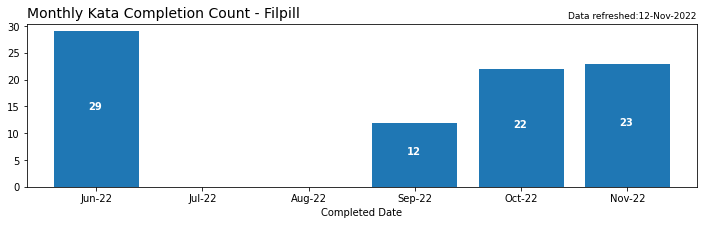

In [19]:
#Plotting a Monthly Completion Rate
fig, ax = plt.subplots(figsize=(12,3))
chart_type = 'bar'
ax = df_monthly_count.plot('Completed Date','Count',kind=chart_type,ax=ax,width=0.8)
ax.set_title(f'Monthly Kata Completion Count - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()

#Text Annotations
[x_offset,y_offset] = [-0.35,2.5] #Data refresh text offset
chart_annotation(df_monthly_count,ax,chart_type,x_offset,y_offset)

#Saving Chart
plt.savefig('charts/monthly_complete.png',dpi=100)

#### Rank Difficulty

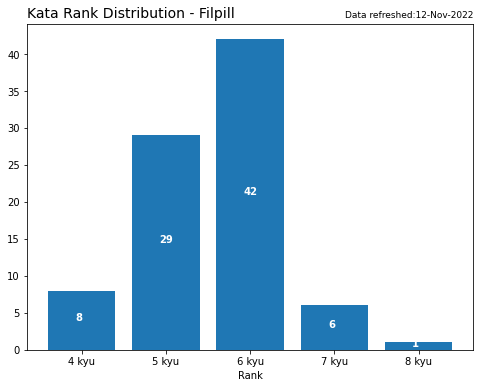

In [20]:
#Plotting Rank Completions
fig, ax = plt.subplots(figsize=(8,6))
chart_type = 'bar'
ax = df_rank_count.plot('Rank','Count',kind=chart_type,ax=ax,width=0.8)
ax.set_title(f'Kata Rank Distribution - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()

# Text Annotations
[x_offset,y_offset] = [-0.35,3] #Data refresh text offset
chart_annotation(df_rank_count,ax,chart_type,x_offset,y_offset)

#Saving Chart
plt.savefig('charts/rank_distribution.png',dpi=100)

#### Languages

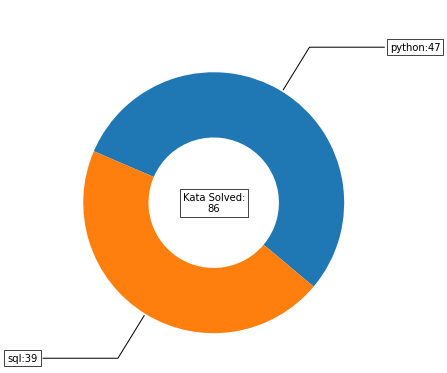

<Figure size 432x288 with 0 Axes>

In [23]:
#Plotting a Monthly Completion Rate
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

data = df_lang['Count']
lang_total = 0
for d in data: lang_total += d
uniques = list(set(df_lang['Languages']))
language_labels = []
for i,r in enumerate(uniques):
    language_labels.append(f'{r}:{data[i]}')

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(language_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title(f'Kata Language Completions - {user}\nData Refreshed: {date_str}',color='white',fontsize=14)
ax.annotate(f'Kata Solved:\n{lang_total}', xy=(0, 0), xytext=(0, 0),
            horizontalalignment='center', **kw)

plt.show()

#Saving Chart
plt.savefig('charts/language_pie.png',dpi=100)

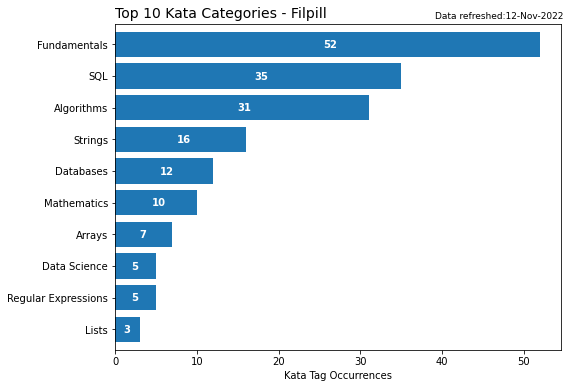

In [40]:
#Plotting Categories
number_of_tags = 10
plot_tags = df_tags.tail(number_of_tags)

fig, ax = plt.subplots(figsize=(8,6))
chart_type = 'barh'
ax = plot_tags.plot('Tags','Count',kind=chart_type,ax=ax,width=0.8)
ax.set_title(f'Top {number_of_tags} Kata Categories - {user}',loc='left',fontsize=14)
ax.tick_params(axis='x',rotation=0)
ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('Kata Tag Occurrences')

# Text Annotations
[x_offset,y_offset] = [-0.2,2.8] #Data refresh text offset
chart_annotation(plot_tags,ax,chart_type,x_offset,y_offset)

#Saving Chart
plt.savefig('charts/top_tags.png',dpi=100)

### Initialising XlsxWriter Workbook And Exporting Tables to .xlsx

In [25]:
#-------------------------------------------------------
#-------------.xlsx workbook initialisation-------------
#-------------------------------------------------------

#Excel Output Filepath
excelpath = pathing('xlsx_data',f'codewars_stats_{user}.xlsx')

#Generating .xlsx workbook in which to record dataframes for usage.
writer = pd.ExcelWriter(excelpath,engine='xlsxwriter')   
workbook=writer.book
worksheet='' #Initialise variable
startrow = 0 #Initialise variable
startcol = 0 #Initialise variable

In [26]:
#Summary Table
data_table = df_profile
sheet_name = 'Stats'
title_str = f'{user} Codewars Stats since {date_str}'
col_width_list = [31,60,22,26,15,15,17,11,60,11,11]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

In [27]:
#Summary Table
data_table = df_kata_combined
sheet_name = 'Stats'
title_str = f'Kata Compeleted By {user} since {date_str}'
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

In [28]:
#Save Excel File Close workbook instance
writer.close()